In [1]:
!pip install SimpleITK nibabel pydicom monai[all] -q
!pip install 'protobuf==3.20.*' -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.

In [2]:
import os
import torch
import pydicom
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, classification_report, 
    accuracy_score, recall_score, precision_score, f1_score
)

from monai.transforms import (
    Spacing, ScaleIntensityRange, Resize, 
    Compose as MonaiCompose
)
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-12-11 16:46:26.091508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765471586.283728      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765471586.337427      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [3]:
# Đường dẫn dữ liệu gốc RSNA
BASE_PATH = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection'
TRAIN_DIR = os.path.join(BASE_PATH, 'stage_2_train')

# Đường dẫn file Metadata (từ dataset study-metadata)
# HÃY KIỂM TRA LẠI ĐƯỜNG DẪN NÀY BÊN THANH INPUT
METADATA_PATH = '/kaggle/input/study-metadata/study_metadata.pkl' 

# Đường dẫn file Model đã train (từ dataset SwintUNETR-V3)
# HÃY KIỂM TRA LẠI ĐƯỜNG DẪN NÀY BÊN THANH INPUT
MODEL_PATH = '/kaggle/input/swintunetr-v3/pytorch/default/1/swin_unetr_ich_3d_best.pth'

print(f"Metadata exists: {os.path.exists(METADATA_PATH)}")
print(f"Model exists: {os.path.exists(MODEL_PATH)}")

Metadata exists: True
Model exists: True


In [4]:
class ICH3DDataset(torch.utils.data.Dataset):
    def __init__(self, studies_df, study_to_slices, train_dir, transforms=None):
        self.studies = studies_df.to_dict('records')
        self.study_to_slices = study_to_slices
        self.train_dir = train_dir
        self.transforms = transforms
    
    def __len__(self):
        return len(self.studies)
    
    def __getitem__(self, idx):
        study_info = self.studies[idx]
        study_id = study_info['study_id']
        label = torch.tensor(study_info['label'], dtype=torch.float32)
        slices = self.study_to_slices[study_id]
        
        # Sort by z position
        slices.sort(key=lambda x: x['z_pos'])
        
        # Stack volume
        volume = []
        for s in slices:
            try:
                dcm_path = os.path.join(self.train_dir, f"{s['slice_id']}.dcm")
                dcm = pydicom.dcmread(dcm_path)
                img = dcm.pixel_array.astype(np.float32)
                
                slope = float(dcm.RescaleSlope) if hasattr(dcm, 'RescaleSlope') else 1.0
                intercept = float(dcm.RescaleIntercept) if hasattr(dcm, 'RescaleIntercept') else 0.0
                img = img * slope + intercept
                
                # Window [-1000, 400]
                img = np.clip(img, -1000, 400)
                img = (img + 1000) / 1400
                volume.append(img)
            except:
                if volume: volume.append(np.zeros_like(volume[0]))
        
        if not volume: volume = [np.zeros((512, 512))]
        
        volume = np.stack(volume, axis=0)
        volume = np.expand_dims(volume, axis=0)
        volume = torch.from_numpy(volume).float()
        
        if self.transforms:
            volume = self.transforms(volume)
        
        return {'image': volume, 'label': label}

# Transforms cho Test (chỉ Resize & Normalize)
val_transforms = MonaiCompose([
    Spacing(pixdim=(1.0, 1.0, 1.0), mode='trilinear'),
    Resize(spatial_size=(96, 96, 96), mode='trilinear'),
    ScaleIntensityRange(a_min=0.0, a_max=1.0, b_min=0.0, b_max=1.0, clip=True)
])

In [5]:
# Cell 5: Load Metadata & Tái tạo Val/Test Split
print("Loading metadata...")
with open(METADATA_PATH, 'rb') as f:
    metadata = pickle.load(f)

study_to_slices = metadata['study_to_slices']

# Tái tạo DataFrame studies
studies = []
for study_id, slices in study_to_slices.items():
    max_label = max([s['label'] for s in slices])
    studies.append({'study_id': study_id, 'label': max_label})
studies_df = pd.DataFrame(studies)

# Split lại (Giống hệt lúc train)
print("Recreating Splits (Train/Val/Test)...")
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(splitter.split(studies_df, studies_df['label']))
temp_df = studies_df.iloc[temp_idx].reset_index(drop=True)

# Split temp thành val/test (50/50 của 30%)
val_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(val_splitter.split(temp_df, temp_df['label']))

val_studies = temp_df.iloc[val_idx].reset_index(drop=True)
test_studies = temp_df.iloc[test_idx].reset_index(drop=True)

print(f"Val Set size : {len(val_studies)}")
print(f"Test Set size: {len(test_studies)}")

# Tạo DataLoaders
val_dataset = ICH3DDataset(val_studies, study_to_slices, TRAIN_DIR, val_transforms)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True
)

test_dataset = ICH3DDataset(test_studies, study_to_slices, TRAIN_DIR, val_transforms)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True
)

Loading metadata...
Recreating Splits (Train/Val/Test)...
Val Set size : 3262
Test Set size: 3262


In [6]:
class SwinUNETRClassifier(torch.nn.Module):
    def __init__(self, in_channels=1, num_classes=1, feature_size=48, use_checkpoint=True):
        super().__init__()
        self.swin_unetr = SwinUNETR(
            spatial_dims=3, in_channels=in_channels, out_channels=2,
            feature_size=feature_size, use_checkpoint=use_checkpoint
        )
        hidden_size = feature_size * 16
        self.classifier = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool3d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(hidden_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        hidden_states_out = self.swin_unetr.swinViT(x, self.swin_unetr.normalize)
        enc_features = hidden_states_out[-1]
        logits = self.classifier(enc_features)
        return logits

In [7]:
print(f"Loading best model from: {MODEL_PATH}")

# Khởi tạo model
model = SwinUNETRClassifier(feature_size=48).to(device)

# Load checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device,  weights_only=False)

# Kiểm tra xem checkpoint lưu full dict hay chỉ state_dict
if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
    print(f"Found 'model_state_dict' key. Best Val AUC was: {checkpoint.get('val_auc', 'N/A')}")
elif 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint

# Load vào model
# Lưu ý: Vì đây là model ĐÃ FINETUNE, keys đã chuẩn, không cần xử lý string nữa
try:
    model.load_state_dict(state_dict)
    print("✅ Model weights loaded successfully!")
except RuntimeError as e:
    print("⚠️ Key mismatch. Attempting to fix keys (removing module. prefix if exists)...")
    # Fix cho trường hợp lưu DataParallel
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    print("✅ Model weights loaded with key correction!")

model.eval()

Loading best model from: /kaggle/input/swintunetr-v3/pytorch/default/1/swin_unetr_ich_3d_best.pth
Found 'model_state_dict' key. Best Val AUC was: 0.8542771384914658
✅ Model weights loaded successfully!


SwinUNETRClassifier(
  (swin_unetr): SwinUNETR(
    (swinViT): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv3d(1, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers1): ModuleList(
        (0): BasicLayer(
          (blocks): ModuleList(
            (0-1): 2 x SwinTransformerBlock(
              (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=48, out_features=144, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=48, out_features=48, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
              (mlp): MLPBlock(
                (linear1): Linear(in_featu

In [8]:
# Cell Mới: Tìm Optimal Threshold trên tập VALIDATION
def find_optimal_threshold(model, loader, device):
    model.eval()
    all_targets = []
    all_probs = []
    
    print("Finding optimal threshold on VALIDATION set...")
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation Inference"):
            inputs = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            
            all_probs.extend(probs.flatten())
            all_targets.extend(labels.cpu().numpy().flatten())
    
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    
    # Tính ROC Curve
    fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
    
    # Cách 1: Youden's J statistic (Sensitivity + Specificity - 1)
    # J = tpr - fpr. Tìm điểm J max.
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    
    print(f"✅ Found Optimal Threshold: {best_thresh:.4f}")
    print(f"   (At this threshold: Sensitivity={tpr[ix]:.4f}, Specificity={1-fpr[ix]:.4f})")
    
    return best_thresh

# Gọi hàm
optimal_threshold = find_optimal_threshold(model, val_loader, device)

Finding optimal threshold on VALIDATION set...


Validation Inference:   0%|          | 0/1631 [00:00<?, ?it/s]

`data_array` is not of type MetaTensor, assuming affine to be identity.


✅ Found Optimal Threshold: 0.1498
   (At this threshold: Sensitivity=0.7269, Specificity=0.8517)


In [9]:
# Cell 8: Chạy Inference trên Test Set
all_targets = []
all_probs = []

print(f"Running inference on Test Set with Threshold = {optimal_threshold:.4f}...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test Inference"):
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        
        all_probs.extend(probs.flatten())
        all_targets.extend(labels.cpu().numpy().flatten())

all_targets = np.array(all_targets)
all_probs = np.array(all_probs)

# ÁP DỤNG NGƯỠNG TỪ TẬP VAL
all_preds = (all_probs > optimal_threshold).astype(int)

print("Inference completed.")

Running inference on Test Set with Threshold = 0.1498...


Test Inference:   0%|          | 0/1631 [00:00<?, ?it/s]

`data_array` is not of type MetaTensor, assuming affine to be identity.


Inference completed.


In [10]:
# Cell 9: Báo cáo kết quả (Final Report)
acc = accuracy_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)
fpr, tpr, _ = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)
tn, fp, fn, tp = confusion_matrix(all_targets, all_preds).ravel()
specificity = tn / (tn + fp)

print("="*60)
print(f"🏥 FINAL TEST RESULTS (Threshold determined by Val: {optimal_threshold:.4f})")
print("="*60)
print(f"🔹 AUC Score      : {roc_auc:.4f}")
print(f"🔹 Accuracy       : {acc:.4f}")
print("-" * 60)
print(f"🔴 RECALL (Sens.) : {recall:.4f}")
print(f"🔵 Specificity    : {specificity:.4f}")
print(f"🔸 Precision      : {precision:.4f}")
print(f"🔸 F1-Score       : {f1:.4f}")
print("="*60)

print("\nConfusion Matrix:")
print(pd.DataFrame(
    confusion_matrix(all_targets, all_preds), 
    columns=['Pred Neg', 'Pred Pos'], 
    index=['True Neg', 'True Pos']
))

🏥 FINAL TEST RESULTS (Threshold determined by Val: 0.1498)
🔹 AUC Score      : 0.8535
🔹 Accuracy       : 0.7961
------------------------------------------------------------
🔴 RECALL (Sens.) : 0.7432
🔵 Specificity    : 0.8326
🔸 Precision      : 0.7540
🔸 F1-Score       : 0.7486

Confusion Matrix:
          Pred Neg  Pred Pos
True Neg      1607       323
True Pos       342       990


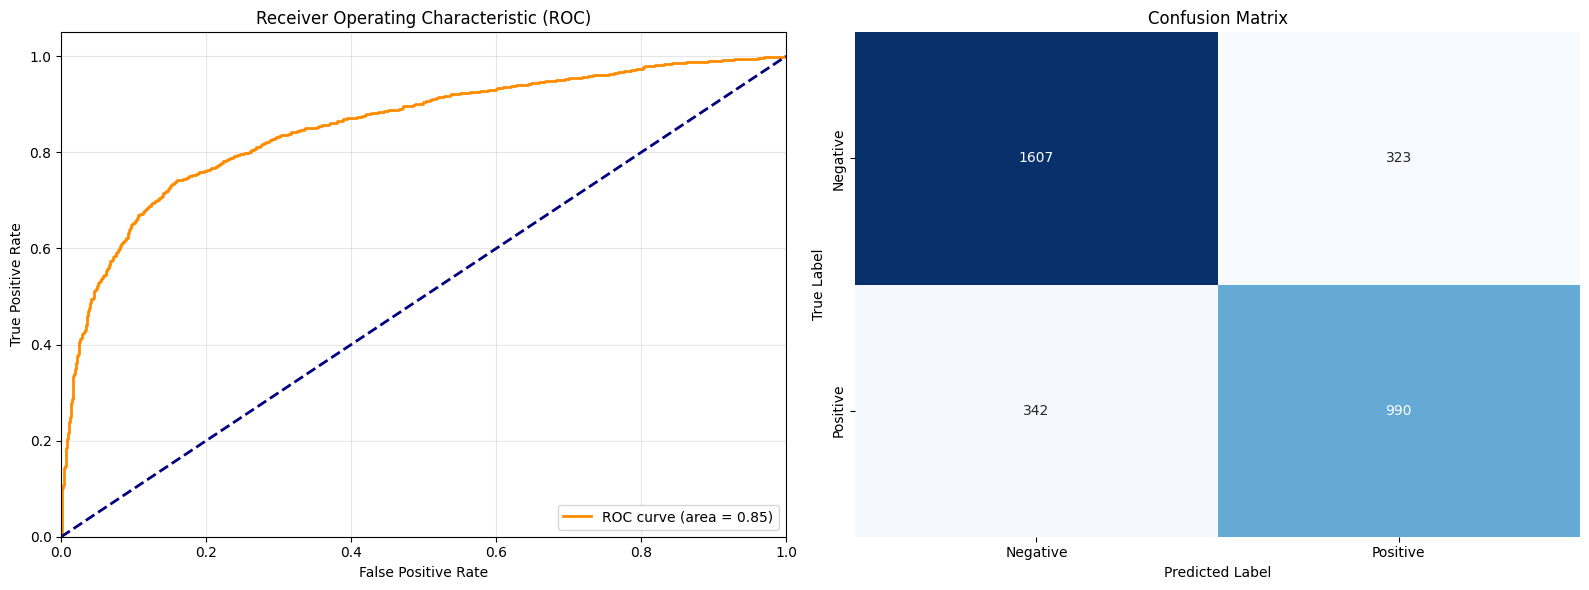

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC)')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# 2. Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()